# Convergence Comparison: JaxPM vs Dorian Ray-Tracing

This notebook compares convergence maps from:
1. **JaxPM Born Approximation**: Fast, approximate lensing
2. **Dorian Born Approximation**: Independent Born implementation from Dorian library
3. **Dorian Full Ray-Tracing**: Includes lens-lens coupling and parallel transport effects

We use the same density planes from JaxPM N-body simulation for all three methods.

## Setup and Imports

In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import sys
import numpy as np
import healpy as hp
import jax
import jax.numpy as jnp
import jax_cosmo as jc
from functools import partial
from diffrax import ODETerm, SaveAt, diffeqsolve, SemiImplicitEuler, ConstantStepSize

sys.path.append('../external/extern/dorian')
from dorian.cosmology import d_c

# Import the modified raytrace function
import importlib.util
spec = importlib.util.spec_from_file_location("dorian_raytracing", "../external/dorian_raytracing.py")
dorian_raytracing = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dorian_raytracing)
raytrace = dorian_raytracing.raytrace

from jaxpm.pm import linear_field, lpt
from jaxpm.ode import symplectic_ode
from jaxpm.lensing import spherical_density_fn, convergence_Born
from jaxpm.kernels import interpolate_power_spectrum

jax.config.update("jax_enable_x64", True)

print(f"✓ JAX backend: {jax.default_backend()}")
print(f"✓ All imports successful!")

/home/wassim/micromamba/envs/jax/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


✓ JAX backend: cpu
✓ All imports successful!


## Configuration Parameters

In [2]:
mesh_size = 256
z_sources = [0.3, 0.5, 0.8]
nside = 256
n_shells = 40
seed = 42

t0, t1 = 0.1, 1.0
dt0 = 0.05

observer_position_in_box = jnp.array([0.5, 0.5, 0.5])

low_ell_cutoff = 2

print("✓ Configuration Parameters:")
print(f"  Mesh size: {mesh_size}³")
print(f"  Source redshifts: {z_sources}")
print(f"  HEALPix nside: {nside} (npix = {hp.nside2npix(nside):,})")
print(f"  Number of shells: {n_shells}")
print(f"  Time range: a = [{t0}, {t1}]")
print(f"  Random seed: {seed}")

✓ Configuration Parameters:
  Mesh size: 256³
  Source redshifts: [0.3, 0.5, 0.8]
  HEALPix nside: 256 (npix = 786,432)
  Number of shells: 40
  Time range: a = [0.1, 1.0]
  Random seed: 42


## Cosmology Setup

In [3]:
Planck18 = partial(
    jc.Cosmology,
    Omega_c=0.2607,
    Omega_b=0.0490,
    Omega_k=0.0,
    h=0.6766,
    n_s=0.9665,
    sigma8=0.8102,
    w0=-1.0,
    wa=0.0,
)

cosmo = Planck18()

print("✓ Cosmology Setup:")
print(f"  H0 = {cosmo.h * 100:.1f} km/s/Mpc")
print(f"  Ωm = {cosmo.Omega_c + cosmo.Omega_b:.4f}")
print(f"  Ωc = {cosmo.Omega_c:.4f}")
print(f"  Ωb = {cosmo.Omega_b:.4f}")
print(f"  σ8 = {cosmo.sigma8:.4f}")
print(f"  n_s = {cosmo.n_s:.4f}")

✓ Cosmology Setup:
  H0 = 67.7 km/s/Mpc
  Ωm = 0.3097
  Ωc = 0.2607
  Ωb = 0.0490
  σ8 = 0.8102
  n_s = 0.9665


## Simulation Geometry

In [4]:
z_max = max(z_sources)
r_comoving = jc.background.radial_comoving_distance(cosmo, jc.utils.z2a(z_max)).squeeze()

factors = jnp.clip(jnp.array(observer_position_in_box), 0.0, 0.5)
factors = 1.0 + 2.0 * jnp.minimum(factors, 1.0 - factors)

box_size = tuple(map(float, factors * r_comoving))
observer_position = jnp.array(observer_position_in_box) * jnp.array(box_size)
d_R = (r_comoving / n_shells).squeeze()
mesh_shape = (mesh_size, mesh_size, mesh_size)

print("✓ Simulation Geometry:")
print(f"  Comoving distance to z={z_max}: {r_comoving:.1f} Mpc/h")
print(f"  Box size: ({box_size[0]:.1f}, {box_size[1]:.1f}, {box_size[2]:.1f}) Mpc/h")
print(f"  Observer position in the box: {observer_position_in_box}")
print(f"  Volume: {(box_size[0] / 1000) ** 3:.2f} (Gpc/h)³")
print(f"  Shell thickness: {d_R:.1f} Mpc/h")
print(f"  Mesh shape: {mesh_shape}")
print(f"  Number of source redshifts: {len(z_sources)}")

✓ Simulation Geometry:
  Comoving distance to z=0.8: 1942.1 Mpc/h
  Box size: (3884.2, 3884.2, 3884.2) Mpc/h
  Observer position in the box: [0.5 0.5 0.5]
  Volume: 58.60 (Gpc/h)³
  Shell thickness: 48.6 Mpc/h
  Mesh shape: (256, 256, 256)
  Number of source redshifts: 3


## JaxPM N-body Simulation

In [5]:
print("=" * 60)
print("JaxPM N-body Simulation")
print("=" * 60)

print("1. Generating initial conditions...")
k = jnp.logspace(-3, 1, 256)
pk = jc.power.linear_matter_power(cosmo, k)
cosmo._workspace = {}

pk_fn = lambda x: interpolate_power_spectrum(x, k, pk, sharding=None)

initial_conditions = linear_field(
    mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(seed), sharding=None
)
print(f"   δ statistics: mean={float(jnp.mean(initial_conditions)):.2e}, "
      f"std={float(jnp.std(initial_conditions)):.3f}")

print("2. Computing LPT displacements...")
dx, p, f = lpt(cosmo, initial_conditions, particles=None, a=t0, order=1,
               sharding=None, halo_size=0)
cosmo._workspace = {}

print("3. Setting up time evolution...")
drift, kick = symplectic_ode(mesh_shape, paint_absolute_pos=False,
                            halo_size=0, sharding=None)
ode_fn = ODETerm(kick), ODETerm(drift)
solver = SemiImplicitEuler()

print("4. Defining spherical shells...")
n_lens = int((box_size[-1] - observer_position[-1]) / d_R)
r = jnp.linspace(0.0, box_size[-1] - observer_position[-1], n_lens)
r_center = 0.5 * (r[1:] + r[:-1])
a_center = jc.background.a_of_chi(cosmo, r_center)
cosmo._workspace = {}
print(f"   Redshift range: z = {float(1 / jnp.max(a_center) - 1):.3f} - "
      f"{float(1 / jnp.min(a_center) - 1):.3f}")
time_steps = a_center[::-1]

saveat = SaveAt(
    ts=time_steps,
    fn=lambda t, y, args: spherical_density_fn(
        mesh_shape, box_size, nside, observer_position, d_R, sharding=None
    )(t, y[1], args),
)

print("5. Running N-body simulation...")
y0 = (p, dx)

res = diffeqsolve(
    ode_fn,
    solver,
    t0=t0,
    t1=t1,
    dt0=dt0,
    y0=y0,
    args=cosmo,
    saveat=saveat,
    stepsize_controller=ConstantStepSize(),
)

density_planes_jaxpm = res.ys
print(f"   Simulation completed: {len(density_planes_jaxpm)} density planes")

print(f"\n✓ JaxPM simulation completed!")
print(f"  Density planes shape: {density_planes_jaxpm.shape}")
print(f"  Shell centers: {len(r_center)} shells")
print(f"  Scale factors: {len(a_center)} values")

JaxPM N-body Simulation
1. Generating initial conditions...
   δ statistics: mean=-1.89e-04, std=0.843
2. Computing LPT displacements...
3. Setting up time evolution...
4. Defining spherical shells...
   Redshift range: z = 0.008 - 0.787
5. Running N-body simulation...


/home/wassim/micromamba/envs/jax/lib/python3.11/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


   Simulation completed: 39 density planes

✓ JaxPM simulation completed!
  Density planes shape: (39, 786432)
  Shell centers: 39 shells
  Scale factors: 39 values


## JaxPM Born Convergence

In [6]:
print("Computing JaxPM Born convergence for multiple redshifts...")

lightcone = density_planes_jaxpm[::-1]

convergence_jaxpm_multi = convergence_Born(
    cosmo, lightcone, r_center, a_center, jnp.array(z_sources), d_R
)

print(f"✓ JaxPM multi-redshift convergence computed:")
print(f"  Shape: {convergence_jaxpm_multi.shape}")
print(f"  Expected shape: ({len(z_sources)}, {hp.nside2npix(nside)})")

for i, z in enumerate(z_sources):
    convergence_z = convergence_jaxpm_multi[i]
    print(f"  z = {z:.1f}: Mean = {float(jnp.mean(convergence_z)):.2e}, "
          f"Std = {float(jnp.std(convergence_z)):.2e}, "
          f"RMS = {float(jnp.sqrt(jnp.mean(convergence_z**2))):.6f}")

print(f"\n✓ All {len(z_sources)} redshift convergence maps computed successfully!")

Computing JaxPM Born convergence for multiple redshifts...
✓ JaxPM multi-redshift convergence computed:
  Shape: (3, 786432)
  Expected shape: (3, 786432)
  z = 0.3: Mean = 2.56e-19, Std = 7.64e-03, RMS = 0.007635
  z = 0.5: Mean = 3.98e-19, Std = 9.93e-03, RMS = 0.009929
  z = 0.8: Mean = 1.12e-18, Std = 1.25e-02, RMS = 0.012512

✓ All 3 redshift convergence maps computed successfully!


## Dorian Preparation

Convert JaxPM density planes to Dorian format:
- Dorian expects mass per pixel in units of $10^{10} M_\odot/h$
- Need to compute particle mass from cosmological parameters

In [7]:
# Convert JaxPM density planes to Dorian format with FIXED units
# Key fix: Use consistent (Mpc/h)^3 units throughout, only convert distances to Mpc for Dorian

print("Converting density planes to Dorian format...")

# Cosmology and particle mass calculation with CORRECT units
omega_m = float(cosmo.Omega_c + cosmo.Omega_b)
omega_l = 1.0 - omega_m
h = float(cosmo.h)

# Compute particle mass in units of 10^10 Msun/h 
rho_crit_h2 = 2.775e11  # Msun / Mpc^3
rho_crit = rho_crit_h2 * h**2  # Msun / Mpc^3
rho_matter = omega_m * rho_crit  # Msun / Mpc^3
volume_box_mpc = (box_size[0] / h)**3  # Mpc^3
n_particles = mesh_size**3
particle_mass_msun = (rho_matter * volume_box_mpc) / n_particles  # Msun
particle_mass_dorian = (particle_mass_msun * h) / 1e10  # 10^10 Msun/h per particle

print(f"   Cosmology: h={h:.3f}, Ωm={omega_m:.4f}, ΩΛ={omega_l:.4f}")
print(f"   Particle mass: {particle_mass_dorian:.3f} × 10¹⁰ M_sun/h")

density_planes_dorian = []
shell_redshifts = []
shell_distances = []

# Build shells: convert JaxPM number-density maps (1/(Mpc/h)^3) to mass-per-pixel (10^10 Msun/h)
for i, (plane, r_i, a_i) in enumerate(zip(lightcone, r_center, a_center)):
    plane_np = np.array(plane)  # number density of particles in (Mpc/h)^-3

    # Shell center redshift and comoving distance in Mpc (for Dorian)
    z_i = float(1.0 / a_i - 1.0)
    d_i = float(d_c(z=z_i, Omega_M=omega_m, Omega_L=omega_l))  # Mpc

    # Pixel volume in (Mpc/h)^3 matching spherical_density_fn normalization
    npix = hp.nside2npix(nside)
    R_min = float(max(r_i - d_R / 2, 0.0))
    R_max = float(min(r_i + d_R / 2, box_size[-1]))
    shell_volume_h = 4.0 / 3.0 * np.pi * (R_max**3 - R_min**3)  # (Mpc/h)^3
    pixel_volume_h = shell_volume_h / npix  # (Mpc/h)^3 per pixel

    # Convert to mass per pixel in units of 10^10 Msun/h
    mass_per_pixel_10 = plane_np * pixel_volume_h * particle_mass_dorian

    density_planes_dorian.append(mass_per_pixel_10)
    shell_redshifts.append(z_i)
    shell_distances.append(d_i)

print(f"   Converted {len(density_planes_dorian)} planes")
print(f"   Redshift range: {shell_redshifts[0]:.3f} to {shell_redshifts[-1]:.3f}")

for i in range(min(3, len(density_planes_dorian))):
    print(
        f"   Plane {i}: z={shell_redshifts[i]:.3f}, "
        f"mean_mass={np.mean(density_planes_dorian[i]):.2e}, "
        f"std_mass={np.std(density_planes_dorian[i]):.2e}"
    )

Converting density planes to Dorian format...
   Cosmology: h=0.677, Ωm=0.3097, ΩΛ=0.6903
   Particle mass: 30018.793 × 10¹⁰ M_sun/h
   Converted 39 planes
   Redshift range: 0.008 to 0.787
   Plane 0: z=0.008, mean_mass=4.81e+00, std_mass=2.14e+02
   Plane 1: z=0.025, mean_mass=3.29e+01, std_mass=5.62e+02
   Plane 2: z=0.042, mean_mass=9.88e+01, std_mass=9.64e+02


## Dorian Ray-Tracing

Run Dorian's full ray-tracing algorithm:
- Born approximation (for comparison with JaxPM)
- Full ray-traced convergence (from distortion matrix)

In [8]:
print("\n" + "=" * 60)
print("Dorian Ray-Tracing")
print("=" * 60)

npix = hp.nside2npix(nside)

# force clean dtypes once
_all_shells     = [np.asarray(m, dtype=np.float64, order="C") for m in density_planes_dorian]
_all_redshifts  = np.asarray(shell_redshifts,  dtype=np.float64)
_all_distances  = np.asarray(shell_distances,  dtype=np.float64)
_omega_m        = float(omega_m)
_omega_l        = float(omega_l)
_nside          = int(nside)
_lmax           = int(3 * _nside)

convergence_dorian_born_multi     = []
convergence_dorian_raytrace_multi = []

for iz, z_source in enumerate(z_sources):
    z_source = float(z_source)
    print(f"\nProcessing z_source = {z_source:.1f}...")

    # shells that actually contribute
    contrib = np.where(_all_redshifts < z_source)[0]

    if contrib.size == 0:
        print(f"  WARNING: No shells contribute to z_source={z_source}")
        convergence_dorian_born_multi.append(np.zeros(npix, dtype=np.float64))
        convergence_dorian_raytrace_multi.append(np.zeros(npix, dtype=np.float64))
        continue

    shells_for_z    = [_all_shells[i] for i in contrib]                 # list[np.ndarray float64]
    redshifts_for_z = _all_redshifts[contrib].astype(np.float64).tolist()
    distances_for_z = _all_distances[contrib].astype(np.float64).tolist()

    print(f"  Using {len(shells_for_z)} shells (z range: {redshifts_for_z[0]:.3f} → {redshifts_for_z[-1]:.3f})")

    try:
        # ---------------------- Born ----------------------
        kappa_born, _, _, _ = raytrace(
            shells=shells_for_z,
            z_s=z_source,
            omega_m=_omega_m,
            omega_l=_omega_l,
            nside=_nside,
            shell_redshifts=redshifts_for_z,
            shell_distances=distances_for_z,
            interp="bilinear",
            parallel_transport=False,
            lmax=_lmax,
            nthreads=1,
        )
        kappa_born = np.asarray(kappa_born, dtype=np.float64)

        # ------------------ Full ray-trace ----------------
        # (parallel_transport=True; use A_final to get kappa)
        _, A_final, _, _ = raytrace(
            shells=shells_for_z,
            z_s=z_source,
            omega_m=_omega_m,
            omega_l=_omega_l,
            nside=_nside,
            shell_redshifts=redshifts_for_z,
            shell_distances=distances_for_z,
            interp="bilinear",
            parallel_transport=True,
            lmax=_lmax,
            nthreads=1,
        )
        # A_final has shape (2, 2, npix)
        A11 = np.asarray(A_final[0, 0], dtype=np.float64)
        A22 = np.asarray(A_final[1, 1], dtype=np.float64)
        kappa_rt = 1.0 - 0.5 * (A11 + A22)

        convergence_dorian_born_multi.append(kappa_born)
        convergence_dorian_raytrace_multi.append(kappa_rt)

        print(f"  Born    RMS: {np.sqrt(np.mean(kappa_born**2)):.6f}")
        print(f"  Raytrace RMS: {np.sqrt(np.mean(kappa_rt**2)):.6f}")

    except Exception as e:
        print(f"  ERROR: {e}")
        import traceback; traceback.print_exc()
        convergence_dorian_born_multi.append(np.zeros(npix, dtype=np.float64))
        convergence_dorian_raytrace_multi.append(np.zeros(npix, dtype=np.float64))

convergence_dorian_born_multi     = np.asarray(convergence_dorian_born_multi, dtype=object)
convergence_dorian_raytrace_multi = np.asarray(convergence_dorian_raytrace_multi, dtype=object)

print(f"\n✓ Dorian convergence computed:")
print(f"  Born shape: {np.shape(convergence_dorian_born_multi)}")
print(f"  Raytrace shape: {np.shape(convergence_dorian_raytrace_multi)}")



Dorian Ray-Tracing

Processing z_source = 0.3...
  Using 17 shells (z range: 0.008 → 0.295)

    ▐▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▌
    ▐                                                               ▌
    ▐   ██████████                       ███                        ▌
    ▐  ░░███░░░░███                     ░░░                         ▌
    ▐   ░███   ░░███  ██████  ████████  ████   ██████   ████████    ▌
    ▐   ░███    ░███ ███░░███░░███░░███░░███  ░░░░░███ ░░███░░███   ▌
    ▐   ░███    ░███░███ ░███ ░███ ░░░  ░███   ███████  ░███ ░███   ▌
    ▐   ░███    ███ ░███ ░███ ░███      ░███  ███░░███  ░███ ░███   ▌
    ▐   ██████████  ░░██████  █████     █████░░████████ ████ █████  ▌
    ▐  ░░░░░░░░░░    ░░░░░░  ░░░░░     ░░░░░  ░░░░░░░░ ░░░░ ░░░░░   ▌
    ▐                                                               ▌
    ▐▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▌
    
Using 17 shells out of 17 total
Shell redshift range: 0.008 t

/home/wassim/Projects/NBody/JaxPM/notebooks/../external/dorian_raytracing.py:132: RuntimeWarning: divide by zero encountered in divide
  alpha_lm = hp.almxfl(kappa_lm, -2 / (np.sqrt((ell * (ell + 1)))))
/home/wassim/Projects/NBody/JaxPM/notebooks/../external/dorian_raytracing.py:133: RuntimeWarning: divide by zero encountered in divide
  f_l = -np.sqrt((ell + 2.0) * (ell - 1.0) / (ell * (ell + 1.0)))
/home/wassim/Projects/NBody/JaxPM/notebooks/../external/dorian_raytracing.py:133: RuntimeWarning: invalid value encountered in sqrt
  f_l = -np.sqrt((ell + 2.0) * (ell - 1.0) / (ell * (ell + 1.0)))


*************************************************************************
Total time: 7 s
Ray tracing finished, bye.
*************************************************************************

    ▐▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▌
    ▐                                                               ▌
    ▐   ██████████                       ███                        ▌
    ▐  ░░███░░░░███                     ░░░                         ▌
    ▐   ░███   ░░███  ██████  ████████  ████   ██████   ████████    ▌
    ▐   ░███    ░███ ███░░███░░███░░███░░███  ░░░░░███ ░░███░░███   ▌
    ▐   ░███    ░███░███ ░███ ░███ ░░░  ░███   ███████  ░███ ░███   ▌
    ▐   ░███    ███ ░███ ░███ ░███      ░███  ███░░███  ░███ ░███   ▌
    ▐   ██████████  ░░██████  █████     █████░░████████ ████ █████  ▌
    ▐  ░░░░░░░░░░    ░░░░░░  ░░░░░     ░░░░░  ░░░░░░░░ ░░░░ ░░░░░   ▌
    ▐                                                               ▌
    ▐▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄

## Visualization: Convergence Maps

/tmp/ipykernel_137531/2214538126.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


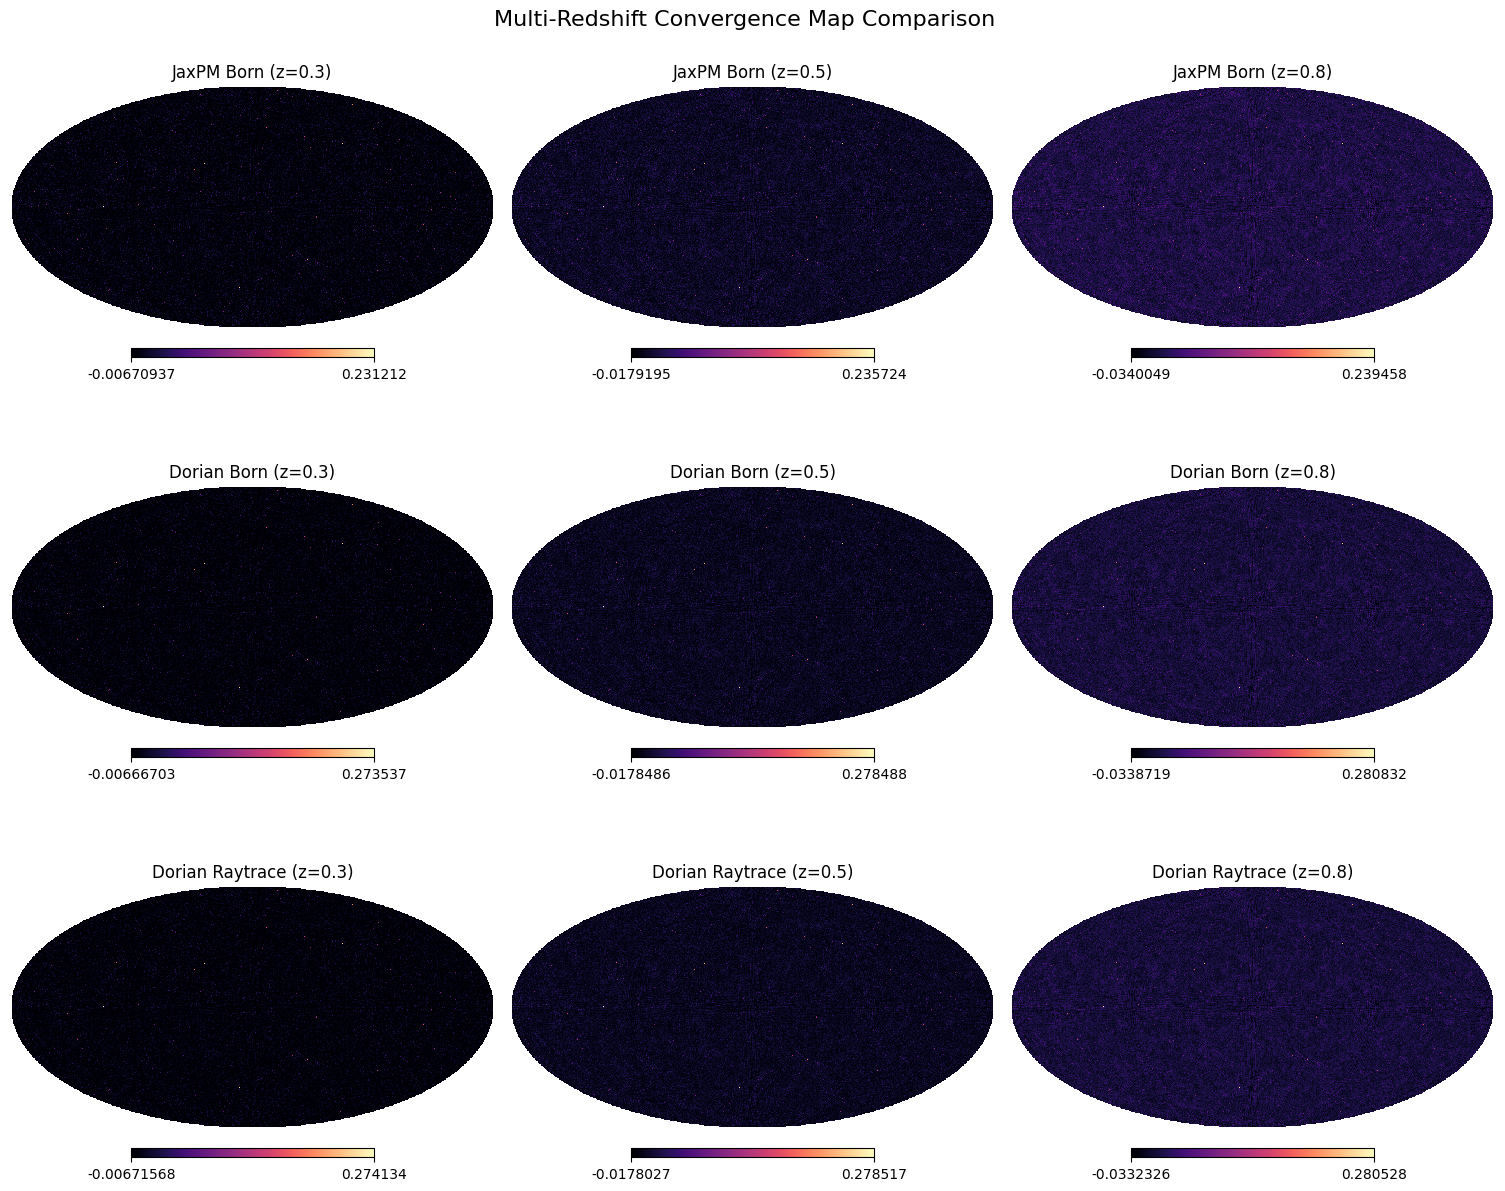

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 12))

for i, z in enumerate(z_sources):
    col = i + 1
    
    # JaxPM map
    hp.mollview(convergence_jaxpm_multi[i], title=f"JaxPM Born (z={z})", 
                cmap="magma", sub=(3, len(z_sources), col), cbar=True, bgcolor=(0,) * 4)
    
    # Dorian Born map
    hp.mollview(convergence_dorian_born_multi[i], title=f"Dorian Born (z={z})", 
                cmap="magma", sub=(3, len(z_sources), col + len(z_sources)), cbar=True, bgcolor=(0,) * 4)
    
    # Dorian Raytrace map
    hp.mollview(convergence_dorian_raytrace_multi[i], title=f"Dorian Raytrace (z={z})", 
                cmap="magma", sub=(3, len(z_sources), col + 2*len(z_sources)), cbar=True, bgcolor=(0,) * 4)

plt.suptitle("Multi-Redshift Convergence Map Comparison", fontsize=16)
plt.tight_layout()
plt.show()

## Difference Maps

/tmp/ipykernel_137531/2184133391.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


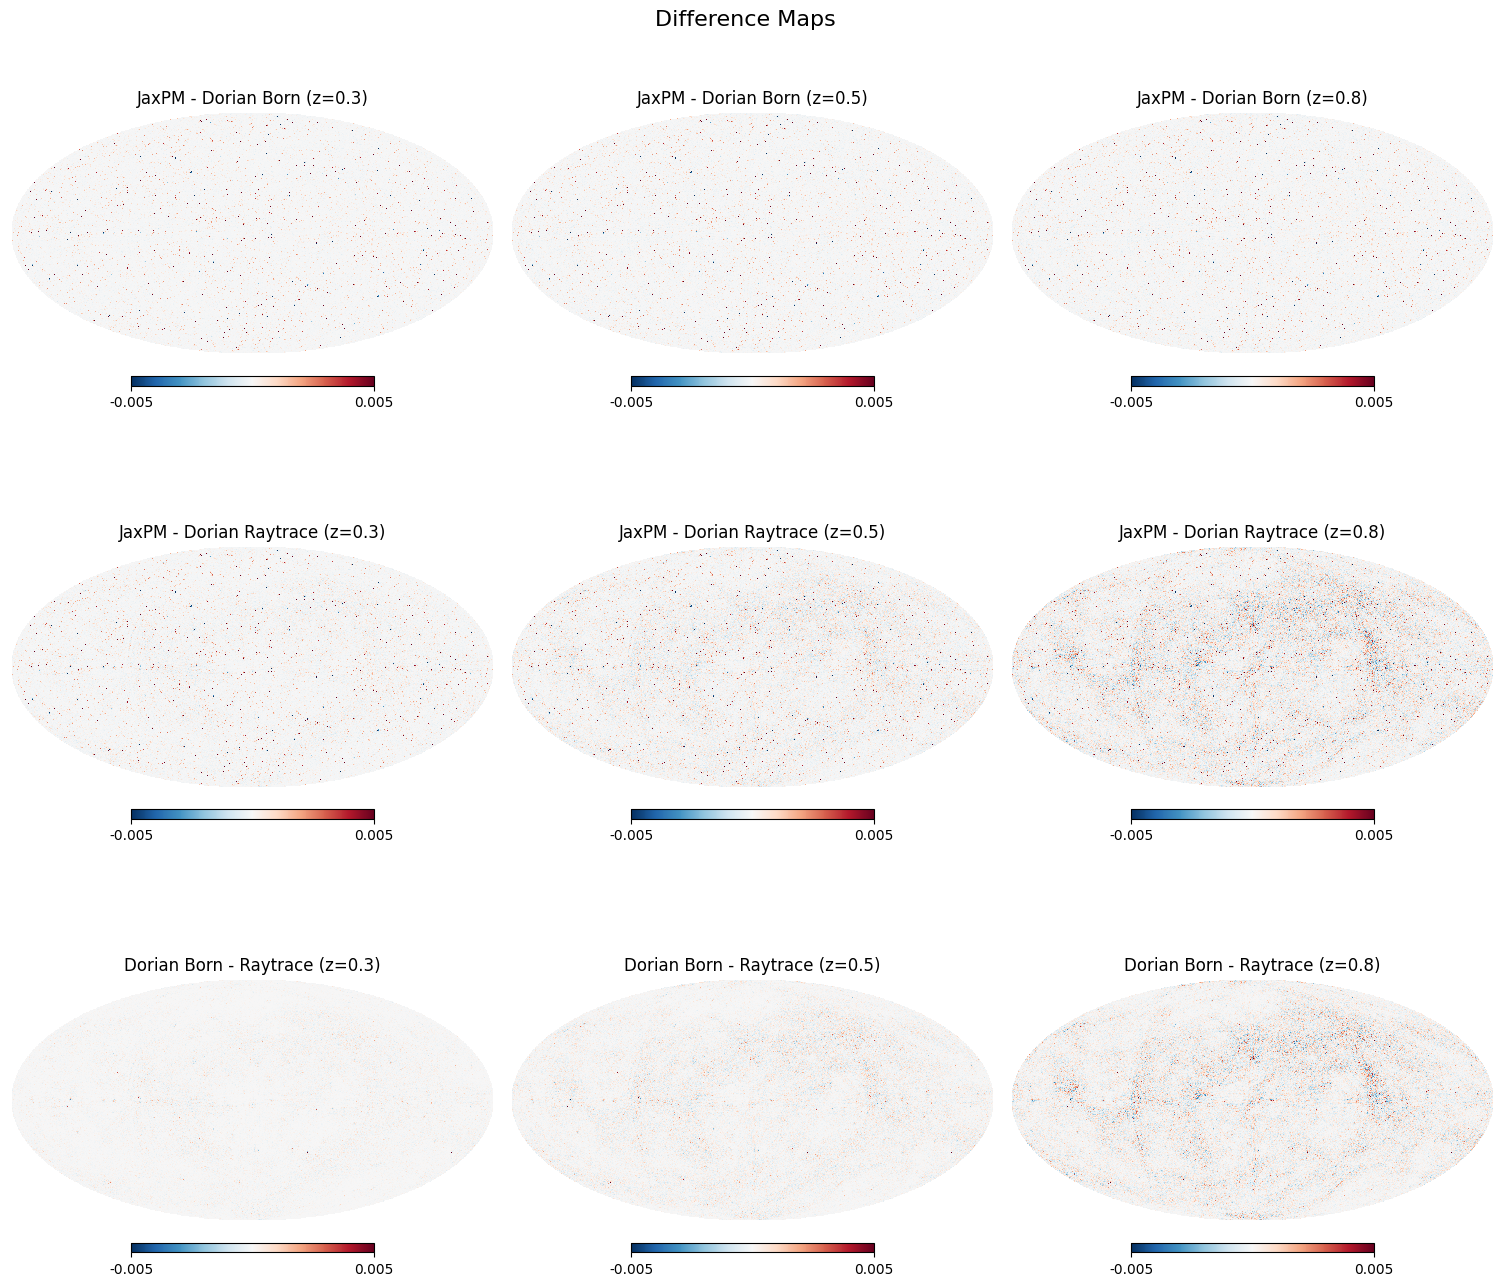

In [10]:
fig = plt.figure(figsize=(15, 13))

for i, z in enumerate(z_sources):
    col = i + 1
    
    diff_jaxpm_dorian_born = np.array(convergence_jaxpm_multi[i]) - convergence_dorian_born_multi[i]
    diff_jaxpm_dorian_raytrace = np.array(convergence_jaxpm_multi[i]) - convergence_dorian_raytrace_multi[i]
    diff_born_raytrace = convergence_dorian_born_multi[i] - convergence_dorian_raytrace_multi[i]
    
    hp.mollview(diff_jaxpm_dorian_born, title=f"JaxPM - Dorian Born (z={z})", 
                sub=(3, len(z_sources), col), cbar=True, min=-0.005, max=0.005, cmap='RdBu_r', bgcolor=(0,) * 4)
    
    hp.mollview(diff_jaxpm_dorian_raytrace, title=f"JaxPM - Dorian Raytrace (z={z})", 
                sub=(3, len(z_sources), col + len(z_sources)), cbar=True, min=-0.005, max=0.005, cmap='RdBu_r', bgcolor=(0,) * 4)
    
    hp.mollview(diff_born_raytrace, title=f"Dorian Born - Raytrace (z={z})", 
                sub=(3, len(z_sources), col + 2*len(z_sources)), cbar=True, min=-0.005, max=0.005, cmap='RdBu_r', bgcolor=(0,) * 4)

plt.suptitle("Difference Maps", fontsize=16)
plt.tight_layout()
plt.show()

## Comparison Statistics

In [11]:
print("\n" + "=" * 80)
print("COMPARISON STATISTICS")
print("=" * 80)

for i, z in enumerate(z_sources):
    jaxpm_rms = np.sqrt(np.mean(convergence_jaxpm_multi[i]**2))
    dorian_born_rms = np.sqrt(np.mean(convergence_dorian_born_multi[i]**2))
    dorian_raytrace_rms = np.sqrt(np.mean(convergence_dorian_raytrace_multi[i]**2))
    
    print(f"\nz = {z:.1f}:")
    print(f"  JaxPM Born:        RMS = {jaxpm_rms:.6f}")
    print(f"  Dorian Born:       RMS = {dorian_born_rms:.6f}")
    print(f"  Dorian Raytrace:   RMS = {dorian_raytrace_rms:.6f}")
    
    diff_jaxpm_dorian_born = np.array(convergence_jaxpm_multi[i]) - convergence_dorian_born_multi[i]
    diff_jaxpm_dorian_raytrace = np.array(convergence_jaxpm_multi[i]) - convergence_dorian_raytrace_multi[i]
    diff_born_raytrace = convergence_dorian_born_multi[i] - convergence_dorian_raytrace_multi[i]
    
    print(f"  JaxPM-Dorian Born: RMS diff = {np.sqrt(np.mean(diff_jaxpm_dorian_born**2)):.6f}")
    print(f"  JaxPM-Dorian Ray:  RMS diff = {np.sqrt(np.mean(diff_jaxpm_dorian_raytrace**2)):.6f}")
    print(f"  Born-Raytrace:     RMS diff = {np.sqrt(np.mean(diff_born_raytrace**2)):.6f}")
    
   
# Power spectrum analysis without theory comparison
print("\n" + "=" * 80)
print("POWER SPECTRUM ANALYSIS")
print("=" * 80)

power_spectrum_results = {}

for i, z in enumerate(z_sources):
    print(f"\nz = {z:.1f}:")
    
    cl_jaxpm = hp.anafast(np.array(convergence_jaxpm_multi[i]))
    cl_dorian_born = hp.anafast(convergence_dorian_born_multi[i])
    cl_dorian_raytrace = hp.anafast(convergence_dorian_raytrace_multi[i])
    
    ell = np.arange(len(cl_jaxpm))
    ell_range = (ell >= 10) & (ell <= 100)
    
    power_spectrum_results[z] = {
        'ell': ell,
        'cl_jaxpm': cl_jaxpm,
        'cl_dorian_born': cl_dorian_born,
        'cl_dorian_raytrace': cl_dorian_raytrace,
    }
    
    if np.any(ell_range):
        ratio_jax_over_born = np.mean(cl_jaxpm[ell_range] / cl_dorian_born[ell_range])
        ratio_jax_over_ray = np.mean(cl_jaxpm[ell_range] / cl_dorian_raytrace[ell_range])
        
        print(f"  Cℓ ratios (ℓ ∈ [10,100]):")
        print(f"    JaxPM / Dorian Born:     {ratio_jax_over_born:.3f}")
        print(f"    JaxPM / Dorian Raytrace: {ratio_jax_over_ray:.3f}")


COMPARISON STATISTICS

z = 0.3:
  JaxPM Born:        RMS = 0.007635
  Dorian Born:       RMS = 0.007600
  Dorian Raytrace:   RMS = 0.007510
  JaxPM-Dorian Born: RMS diff = 0.000637
  JaxPM-Dorian Ray:  RMS diff = 0.000690
  Born-Raytrace:     RMS diff = 0.000222

z = 0.5:
  JaxPM Born:        RMS = 0.009929
  Dorian Born:       RMS = 0.009886
  Dorian Raytrace:   RMS = 0.009700
  JaxPM-Dorian Born: RMS diff = 0.000658
  JaxPM-Dorian Ray:  RMS diff = 0.000795
  Born-Raytrace:     RMS diff = 0.000418

z = 0.8:
  JaxPM Born:        RMS = 0.012512
  Dorian Born:       RMS = 0.012461
  Dorian Raytrace:   RMS = 0.012136
  JaxPM-Dorian Born: RMS diff = 0.000670
  JaxPM-Dorian Ray:  RMS diff = 0.000982
  Born-Raytrace:     RMS diff = 0.000691

POWER SPECTRUM ANALYSIS

z = 0.3:
  Cℓ ratios (ℓ ∈ [10,100]):
    JaxPM / Dorian Born:     1.002
    JaxPM / Dorian Raytrace: 1.003

z = 0.5:
  Cℓ ratios (ℓ ∈ [10,100]):
    JaxPM / Dorian Born:     1.005
    JaxPM / Dorian Raytrace: 1.007

z = 0.8:
  C

## Power Spectrum Visualization

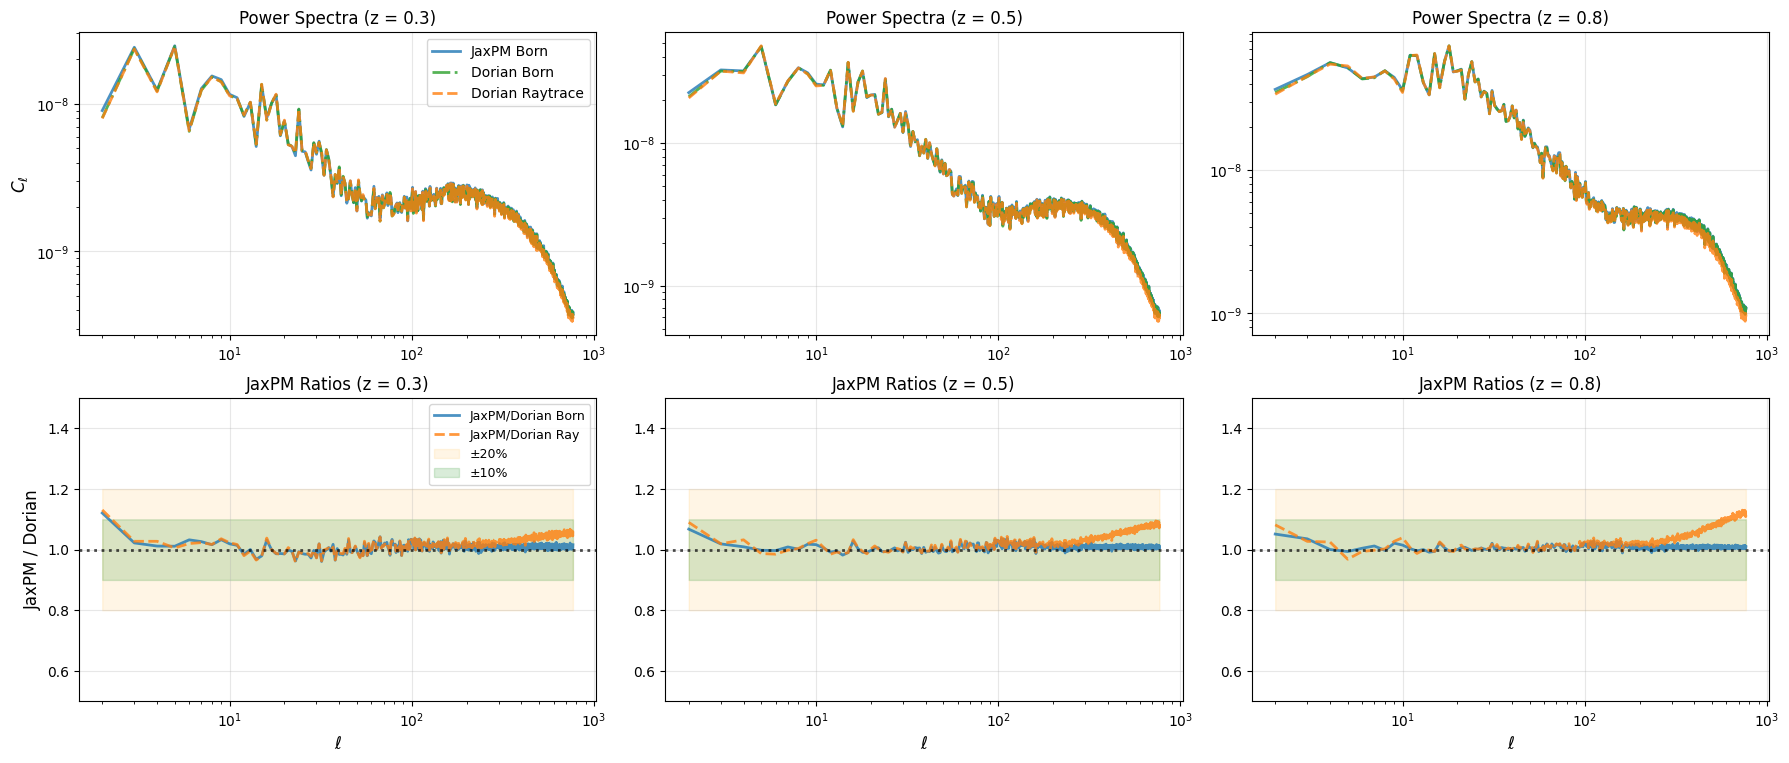

In [12]:
fig, axes = plt.subplots(2, len(z_sources), figsize=(18, 8))
colors = {
    'jaxpm': '#1f77b4',
    'dorian_born': '#2ca02c',
    'dorian_raytrace': '#ff7f0e',
}

for col, z in enumerate(z_sources):
    results = power_spectrum_results[z]
    ell = results['ell'][low_ell_cutoff:]
    cl_jaxpm = results['cl_jaxpm'][low_ell_cutoff:]
    cl_dorian_born = results['cl_dorian_born'][low_ell_cutoff:]
    cl_dorian_raytrace = results['cl_dorian_raytrace'][low_ell_cutoff:]
    
    # Row 1: Power spectra
    ax1 = axes[0, col]
    ax1.loglog(ell, cl_jaxpm, '-', color=colors['jaxpm'], linewidth=2, alpha=0.8, label='JaxPM Born')
    ax1.loglog(ell, cl_dorian_born, '-.', color=colors['dorian_born'], linewidth=2, alpha=0.8, label='Dorian Born')
    ax1.loglog(ell, cl_dorian_raytrace, '--', color=colors['dorian_raytrace'], linewidth=2, alpha=0.8, label='Dorian Raytrace')
    
    ax1.set_title(f'Power Spectra (z = {z:.1f})', fontsize=12)
    if col == 0:
        ax1.set_ylabel(r'$C_\ell$', fontsize=12)
        ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Row 2: Ratios JaxPM/Dorian (not against theory)
    ax2 = axes[1, col]
    valid_born = cl_dorian_born > 0
    valid_ray = cl_dorian_raytrace > 0
    ratio_jax_over_born = np.where(valid_born, cl_jaxpm / cl_dorian_born, np.nan)
    ratio_jax_over_ray = np.where(valid_ray, cl_jaxpm / cl_dorian_raytrace, np.nan)
    
    ax2.semilogx(ell, ratio_jax_over_born, '-', color=colors['jaxpm'], linewidth=2, alpha=0.8, label='JaxPM/Dorian Born')
    ax2.semilogx(ell, ratio_jax_over_ray, '--', color=colors['dorian_raytrace'], linewidth=2, alpha=0.8, label='JaxPM/Dorian Ray')
    ax2.axhline(1, color='black', linestyle=':', alpha=0.7, linewidth=2)
    
    ax2.fill_between(ell, 0.8, 1.2, alpha=0.1, color='orange', label='±20%' if col == 0 else '')
    ax2.fill_between(ell, 0.9, 1.1, alpha=0.15, color='green', label='±10%' if col == 0 else '')
    
    ax2.set_title(f'JaxPM Ratios (z = {z:.1f})', fontsize=12)
    ax2.set_xlabel(r'$\ell$', fontsize=12)
    if col == 0:
        ax2.set_ylabel('JaxPM / Dorian', fontsize=12)
        ax2.legend(fontsize=9, loc='best')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0.5, 1.5)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [13]:
# Maximum percentage deviation between JaxPM and Dorian Born
ratio_jax_over_born_abs = np.abs(ratio_jax_over_born)
max_dev_jaxpm_born = np.max(ratio_jax_over_born_abs - 1)
mean_dev_jaxpm_born = np.mean(np.abs(ratio_jax_over_born - 1))
print(f"\nMaximum percentage deviation between JaxPM and Dorian Born at z={z_sources[i]}: {max_dev_jaxpm_born*100:.2f}%")
print(f"Mean percentage deviation between JaxPM and Dorian Born at z={z_sources[i]}: {mean_dev_jaxpm_born*100:.2f}%")
# Between ells 10 and 700
ratio_jax_over_born_abs_10_700 = np.abs(ratio_jax_over_born[20:500])
max_dev_jaxpm_born = np.max(ratio_jax_over_born_abs_10_700 - 1)
mean_dev_jaxpm_born = np.mean(ratio_jax_over_born_abs_10_700 - 1)
print(f"Maximum percentage deviation between JaxPM and Dorian Born at z={z_sources[i]}: {max_dev_jaxpm_born*100:.2f}%")
print(f"Mean percentage deviation between JaxPM and Dorian Born at z={z_sources[i]}: {mean_dev_jaxpm_born*100:.2f}%")


Maximum percentage deviation between JaxPM and Dorian Born at z=0.8: 5.13%
Mean percentage deviation between JaxPM and Dorian Born at z=0.8: 0.86%
Maximum percentage deviation between JaxPM and Dorian Born at z=0.8: 2.95%
Mean percentage deviation between JaxPM and Dorian Born at z=0.8: 0.84%


In [14]:
import itertools

import scienceplots  # noqa: F401

# Set the style for the plots
plt.style.use("science")
font_size = 14
plt.rcParams.update(
    {
        "font.size": font_size,
        "axes.labelsize": font_size,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "legend.fontsize": font_size,
        "axes.titlesize": font_size,
        "font.family": "serif",  # or 'Times New Roman' to match LaTeX
        "legend.frameon": True,  # Add boxed legends
    }
)


# Create killer 2×2 publication plot for z = 0.8
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Use z = 0.8 (index 2 in z_sources)
z_idx = 2
z_val = z_sources[z_idx]

# Prepare data for z = 0.8
kappa_jaxpm = np.array(convergence_jaxpm_multi[z_idx])
kappa_dorian_born = convergence_dorian_born_multi[z_idx]
diff_map = kappa_jaxpm - kappa_dorian_born

# Power spectrum data for z = 0.8
ps_data = power_spectrum_results[z_val]
ell = ps_data['ell'][low_ell_cutoff:]
cl_jaxpm = ps_data['cl_jaxpm'][low_ell_cutoff:]
cl_dorian_born = ps_data['cl_dorian_born'][low_ell_cutoff:]

# ===== TOP-LEFT: JaxPM-Born convergence map =====
ax_tl = axes[0, 0]
plt.sca(ax_tl)
hp.mollview(kappa_jaxpm, title=f"JaxPM–Born (z = {z_val})", 
            cmap="viridis", cbar=True, bgcolor=(1,)*4, hold=True)
ax_tl.set_title(f"JaxPM–Born (z = {z_val})", fontsize=14, fontweight='bold', pad=20)

# ===== TOP-RIGHT: Auto-spectra comparison =====
ax_tr = axes[0, 1]
ax_tr.loglog(ell, cl_jaxpm, 'o-', color='#1f77b4', linewidth=2.5, markersize=4, 
             alpha=0.8, label='JaxPM–Born (spherical)', markerfacecolor='white', markeredgewidth=1.5)
ax_tr.loglog(ell, cl_dorian_born, '--', color='#ff7f0e', linewidth=3, 
             alpha=0.9, label='Dorian (Born)')

ax_tr.set_xlabel(r'$\ell$', fontsize=13, fontweight='bold')
ax_tr.set_ylabel(r'$C_\ell^{\kappa\kappa}$', fontsize=13, fontweight='bold')
ax_tr.set_title(f'Auto-spectra (z = {z_val})', fontsize=14, fontweight='bold')
ax_tr.legend(fontsize=11, frameon=True, fancybox=True, shadow=True, loc='upper right')
ax_tr.grid(True, alpha=0.3, which='both')
ax_tr.tick_params(labelsize=11)

# ===== BOTTOM-LEFT: Difference map =====
ax_bl = axes[1, 0]
plt.sca(ax_bl)
hp.mollview(diff_map, title=f"Difference (JaxPM − Dorian)", 
            cmap="RdBu_r", cbar=True, min=-0.005, max=0.005, bgcolor=(1,)*4, hold=True)
ax_bl.set_title("Difference (JaxPM − Dorian)", fontsize=14, fontweight='bold', pad=20)

# ===== BOTTOM-RIGHT: Ratio plot =====
ax_br = axes[1, 1]
valid_indices = (cl_dorian_born > 0) & (ell >= 10) & (ell <= 500)
ell_valid = ell[valid_indices]
ratio = cl_jaxpm[valid_indices] / cl_dorian_born[valid_indices]

ax_br.semilogx(ell_valid, ratio, 'o-', color='#2ca02c', linewidth=2.5, markersize=4, 
               alpha=0.8, markerfacecolor='white', markeredgewidth=1.5, 
               label=f'JaxPM / Dorian (z = {z_val})')

# Add shaded band for ±2% agreement
ax_br.fill_between(ell_valid, 0.98, 1.02, alpha=0.2, color='lightblue', 
                   label='±2% target', zorder=0)
ax_br.axhline(1, color='black', linestyle='-', alpha=0.7, linewidth=2, zorder=1)

ax_br.set_xlabel(r'$\ell$', fontsize=13, fontweight='bold')
ax_br.set_ylabel(r'$R_\ell = C_\ell^{\text{JaxPM}} / C_\ell^{\text{Dorian}}$', fontsize=13, fontweight='bold')
ax_br.set_title('Ratio (JaxPM / Dorian)', fontsize=14, fontweight='bold')
ax_br.set_ylim(0.90, 1.1)
ax_br.legend(fontsize=11, frameon=True, fancybox=True, shadow=True, loc='upper right')
ax_br.grid(True, alpha=0.3, which='both')
ax_br.tick_params(labelsize=11)

# Overall styling
plt.tight_layout(pad=3.0)
fig.suptitle(f'Convergence Analysis: JaxPM vs Dorian (z = {z_val})', 
             fontsize=16, fontweight='bold', y=0.98)

# Add some statistics as text
mean_ratio = np.mean(ratio)
std_ratio = np.std(ratio)
max_dev = np.max(np.abs(ratio - 1)) * 100

plt.savefig(f'kappa_power_vs_dorian.pdf', dpi=300)
plt.show()

print(f"\\n✓ Killer 2×2 plot created for z = {z_val}!")
print(f"  Mean power spectrum ratio: {mean_ratio:.4f}")
print(f"  Standard deviation: {std_ratio:.4f}")
print(f"  Maximum deviation from unity: {max_dev:.2f}%")

ModuleNotFoundError: No module named 'scienceplots'